In [32]:
# pip uninstall numpy pandas -y
!pip install numpy==1.24.4
!pip install pandas==1.5.3



[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


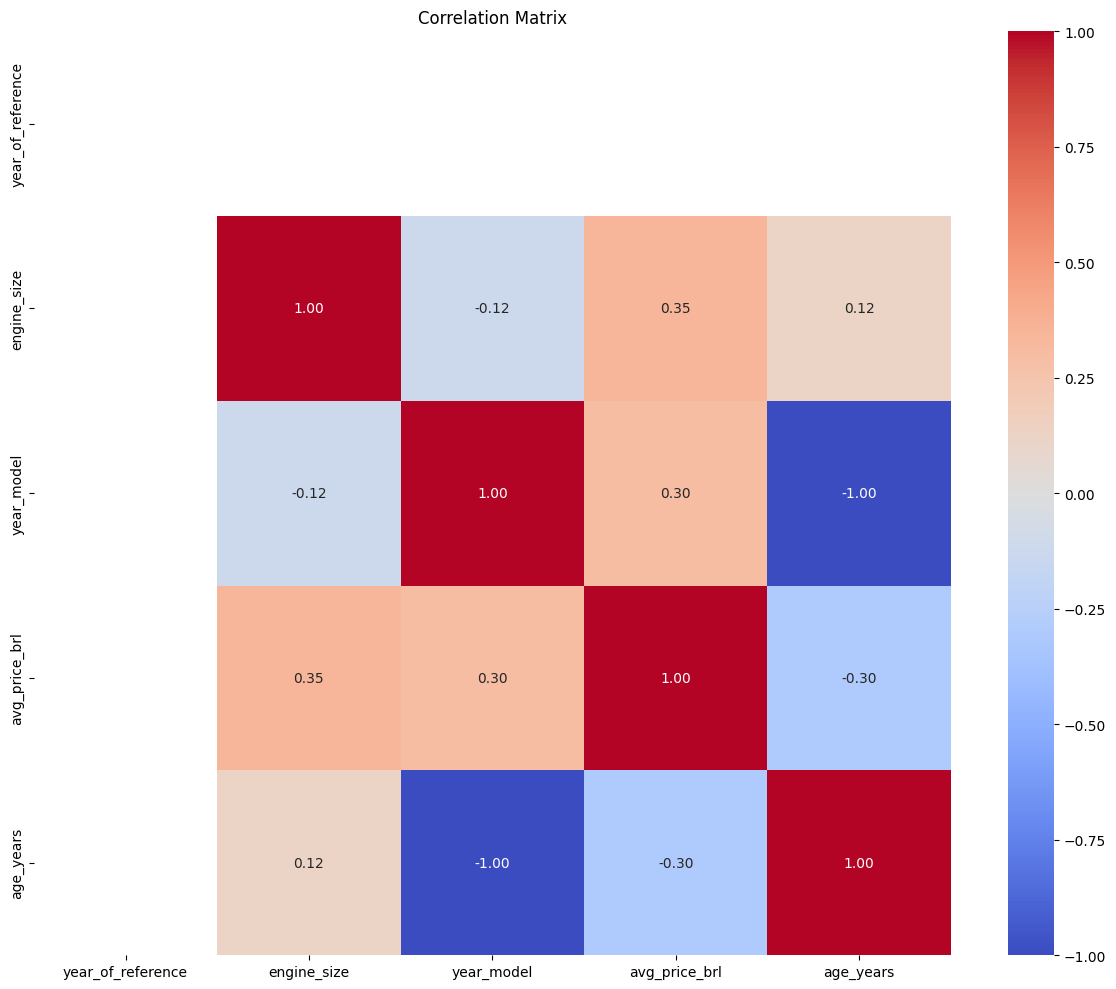

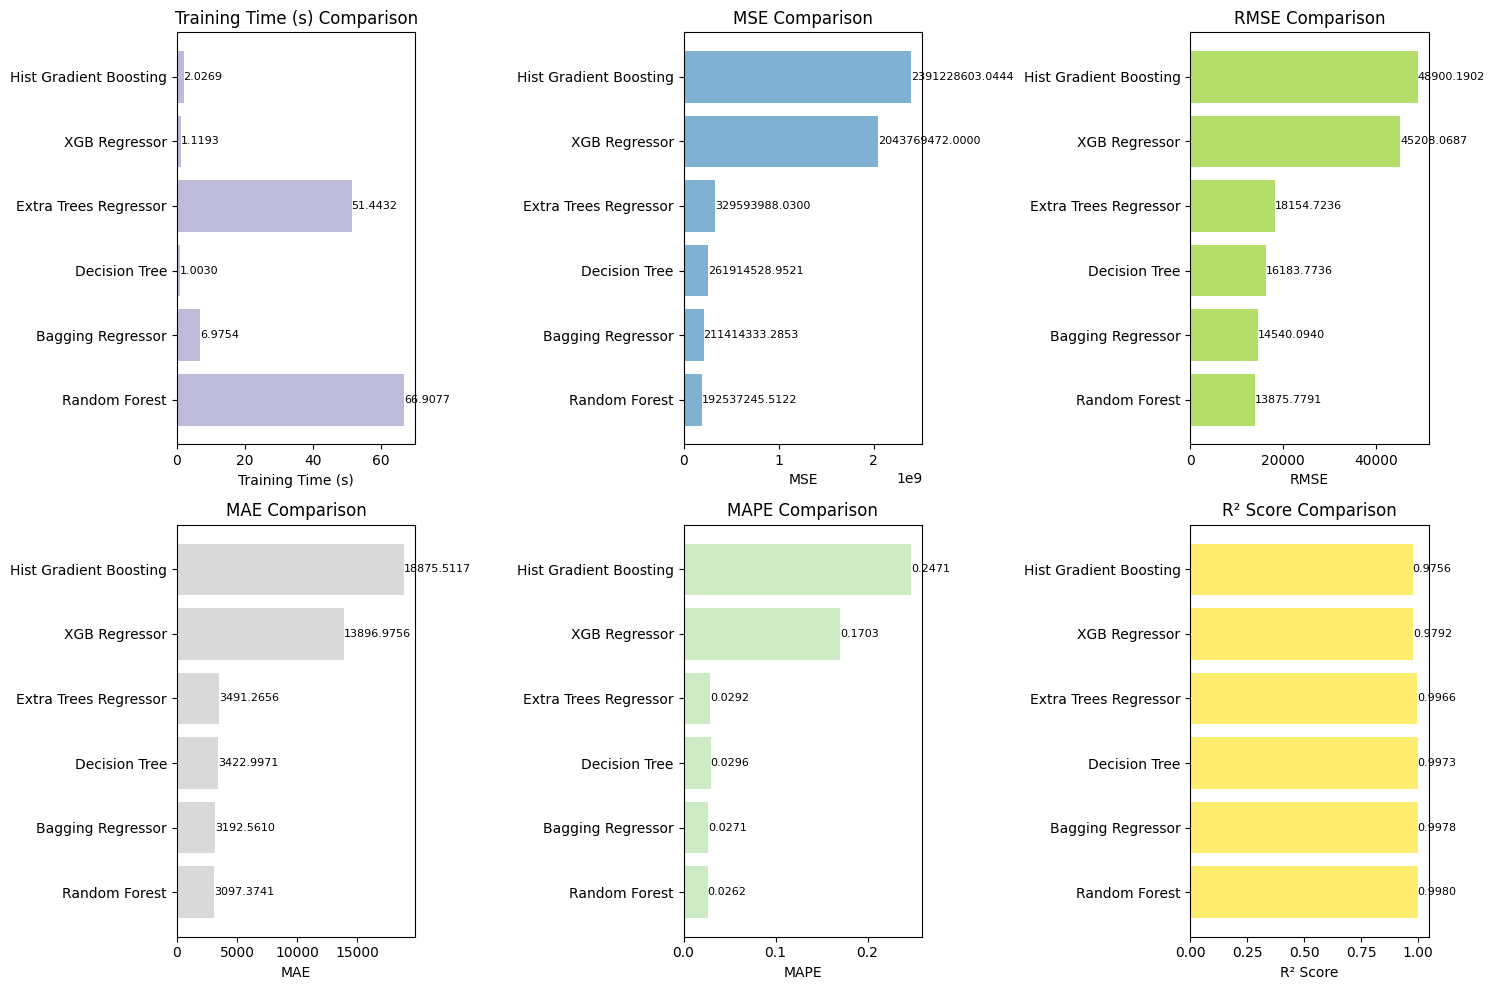

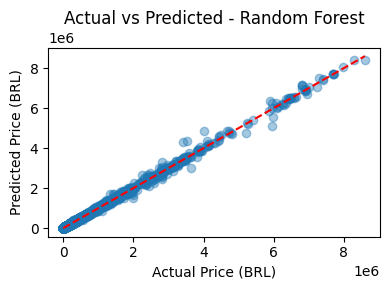

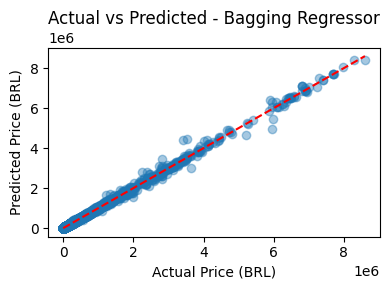

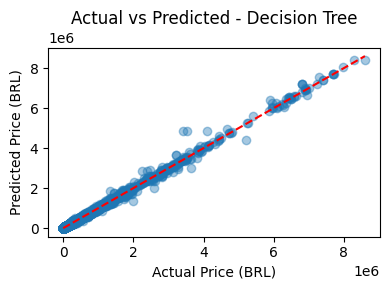

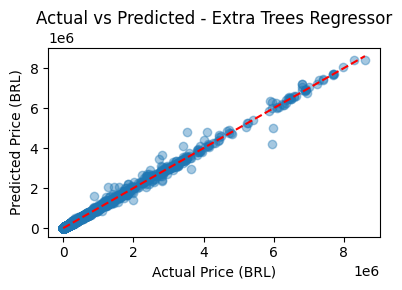

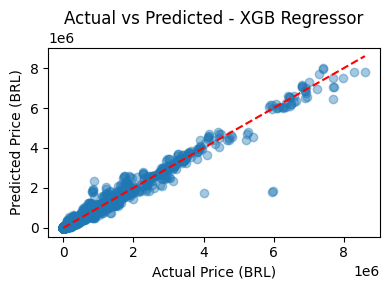

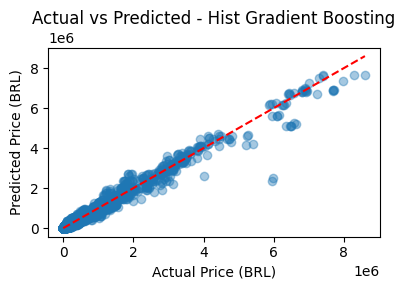

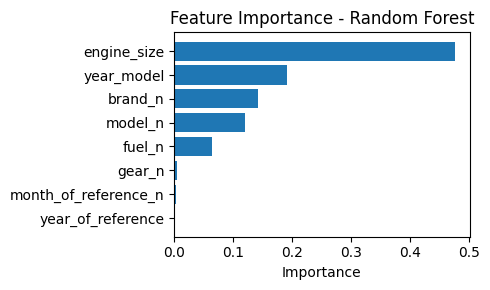

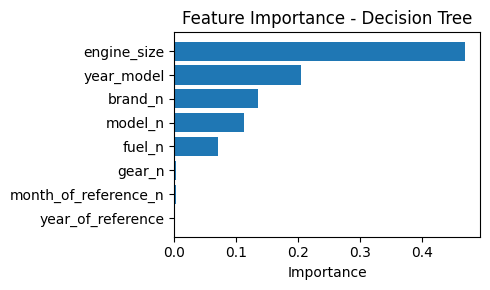

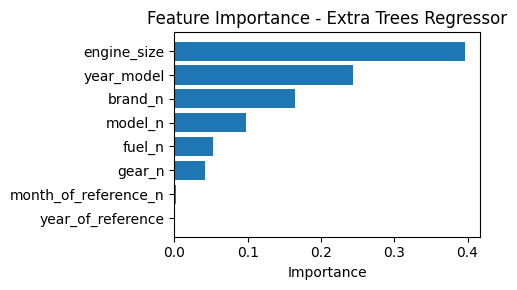

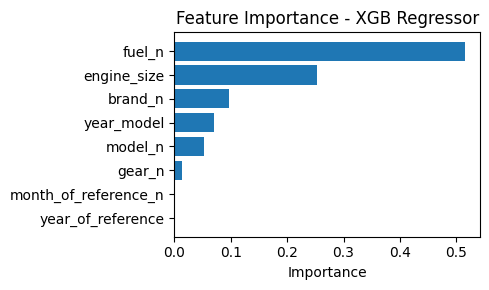


🚀 Recommended Best Model: **Random Forest**
Reason: has excellent predictive power (R² ≥ 0.9), has the lowest MAE, has the lowest MAPE.

Final Model Comparison:


,Model,Training Time (s),MSE,RMSE,MAE,MAPE,R² Score
0,Random Forest,66.907744,1.925372e+08,13875.779096,3097.374055,0.026214,0.998039
1,Bagging Regressor,6.975412,2.114143e+08,14540.093992,3192.561019,0.027136,0.997847
2,Decision Tree,1.002955,2.619145e+08,16183.773631,3422.997115,0.029584,0.997333
3,Extra Trees Regressor,51.443213,3.295940e+08,18154.723573,3491.265641,0.029174,0.996643
4,XGB Regressor,1.119347,2.043769e+09,45208.068660,13896.975586,0.170298,0.979185
5,Hist Gradient Boosting,2.026937,2.391229e+09,48900.190215,18875.511679,0.247135,0.975646


In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Load the dataset
df = pd.read_csv('C:/Users/adity/z class work/RIC/Brazil fipe_2022.csv')

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Label Encoding
inputs = df.drop(['fipe_code', 'authentication', 'avg_price_brl', 'age_years'], axis='columns')
y = df['avg_price_brl']

for col in ['month_of_reference', 'brand', 'model', 'fuel', 'gear']:
    le = LabelEncoder()
    inputs[col + '_n'] = le.fit_transform(inputs[col])

X = inputs.drop(['month_of_reference', 'brand', 'model', 'fuel', 'gear'], axis='columns')

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Bagging Regressor': BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Extra Trees Regressor': ExtraTreesRegressor(random_state=42),
    'XGB Regressor': XGBRegressor(random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state=42)
}

results = pd.DataFrame(columns=[
    'Model', 'Training Time (s)', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R² Score'
])
predictions = {}

# Train, predict, evaluate
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results = pd.concat([results, pd.DataFrame({
        'Model': [name],
        'Training Time (s)': [training_time],
        'MSE': [mse], 'RMSE': [rmse],
        'MAE': [mae], 'MAPE': [mape],
        'R² Score': [r2]
    })], ignore_index=True)

results = results.sort_values('R² Score', ascending=False).reset_index(drop=True)

# Metrics visualization
def create_multi_metric_plot(df, metrics):
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        bars = plt.barh(df['Model'], df[metric], color=plt.cm.Set3(i/len(metrics)))
        plt.title(f'{metric} Comparison')
        plt.xlabel(metric)
        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', ha='left', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()

create_multi_metric_plot(results, ['Training Time (s)', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R² Score'])

# Actual vs Predicted for all models
for model_name, y_pred in predictions.items():
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Price (BRL)")
    plt.ylabel("Predicted Price (BRL)")
    plt.title(f"Actual vs Predicted - {model_name}")
    plt.tight_layout()
    plt.show()

# Feature importance plots
def plot_feature_importance(model, name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)
        plt.figure(figsize=(5, 3))
        plt.barh(np.array(X.columns)[sorted_idx], importances[sorted_idx])
        plt.title(f"Feature Importance - {name}")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

for name, model in models.items():
    plot_feature_importance(model, name)

# Best model recommender
def recommend_best_model(results_df):
    best = results_df.iloc[0]
    reason = []
    
    if best['R² Score'] >= 0.9:
        reason.append("has excellent predictive power (R² ≥ 0.9)")
    if best['MAE'] == results_df['MAE'].min():
        reason.append("has the lowest MAE")
    if best['MAPE'] == results_df['MAPE'].min():
        reason.append("has the lowest MAPE")
    if best['Training Time (s)'] <= results_df['Training Time (s)'].median():
        reason.append("trains relatively fast")
    
    print(f"\n🚀 Recommended Best Model: **{best['Model']}**")
    print("Reason:", ", ".join(reason) + ".")
    return best['Model']

recommended_model = recommend_best_model(results)

# Show final comparison table
print("\nFinal Model Comparison:")
display(results)


In [7]:
# pip install -U numpy pandas matplotlib seaborn scikit-learn xgboost

In [17]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('C:/Users/adity/z class work/RIC/Brazil fipe_2022.csv')

# Label Encoding
inputs = df.drop(['fipe_code', 'authentication', 'avg_price_brl', 'age_years'], axis='columns')
y = df['avg_price_brl']

for col in ['month_of_reference', 'brand', 'model', 'fuel', 'gear']:
    le = LabelEncoder()
    inputs[col + '_n'] = le.fit_transform(inputs[col])

X = inputs.drop(['month_of_reference', 'brand', 'model', 'fuel', 'gear'], axis='columns')

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Bagging Regressor': BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Extra Trees Regressor': ExtraTreesRegressor(random_state=42),
    'XGB Regressor': XGBRegressor(random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state=42)
}

results = []
feature_importances = {}
predictions = {}

# Train and evaluate models
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Training Time (s)': training_time,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2
    })

    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = dict(zip(X.columns, model.feature_importances_))

# Sort by R² Score
results_df = pd.DataFrame(results).sort_values('R² Score', ascending=False).reset_index(drop=True)

# Output: Model Performance Summary
print("\n=== Model Performance Summary ===")
for _, row in results_df.iterrows():
    print(f"{row['Model']}: Time={row['Training Time (s)']:.4f}s, "
          f"R²={row['R² Score']:.4f}, MSE={row['MSE']:.4f}, "
          f"RMSE={row['RMSE']:.4f}, MAE={row['MAE']:.4f}")



# Output: Feature Importances
print("\n=== Feature Importances ===")
for model_name, importances in feature_importances.items():
    print(f"\n{model_name}:")
    for feature, value in importances.items():
        print(f"  {feature}: {value:.4f}")

# Output: Actual vs Predicted (First 100)
print("\n=== Actual vs Predicted (First 100 values) ===")
for model_name, y_pred in predictions.items():
    print(f"\n{model_name}:")
    for actual, predicted in zip(y_test[:100], y_pred[:100]):
        print(f"  Actual: {actual:.2f}, Predicted: {predicted:.2f}")

# Recommend Best Model
def recommend_best_model(df):
    best = df.iloc[0]
    reasons = []

    if best['R² Score'] >= 0.9:
        reasons.append("excellent accuracy (R² ≥ 0.9)")
    if best['MAE'] == df['MAE'].min():
        reasons.append("lowest Mean Absolute Error (MAE)")
    if best['MSE'] == df['MSE'].min():
        reasons.append("lowest Mean Squared Error (MSE)")
    if best['Training Time (s)'] <= df['Training Time (s)'].median():
        reasons.append("fast training time")

    print(f"\n🚀 Recommended Best Model: {best['Model']}")
    print("Why it's recommended:", ", ".join(reasons) + ".")

recommend_best_model(results_df)



=== Model Performance Summary ===
Random Forest: Time=69.0738s, R²=0.9980, MSE=192537245.5122, RMSE=13875.7791, MAE=3097.3741
Bagging Regressor: Time=7.0167s, R²=0.9978, MSE=211414333.2853, RMSE=14540.0940, MAE=3192.5610
Decision Tree: Time=1.0184s, R²=0.9973, MSE=261914528.9521, RMSE=16183.7736, MAE=3422.9971
Extra Trees Regressor: Time=46.8479s, R²=0.9966, MSE=329593988.0300, RMSE=18154.7236, MAE=3491.2656
XGB Regressor: Time=0.6658s, R²=0.9792, MSE=2043769472.0000, RMSE=45208.0687, MAE=13896.9756
Hist Gradient Boosting: Time=1.0106s, R²=0.9756, MSE=2391228603.0444, RMSE=48900.1902, MAE=18875.5117

=== Feature Importances ===

Random Forest:
  year_of_reference: 0.0000
  engine_size: 0.4767
  year_model: 0.1915
  month_of_reference_n: 0.0020
  brand_n: 0.1411
  model_n: 0.1205
  fuel_n: 0.0636
  gear_n: 0.0045

Decision Tree:
  year_of_reference: 0.0000
  engine_size: 0.4708
  year_model: 0.2046
  month_of_reference_n: 0.0022
  brand_n: 0.1352
  model_n: 0.1133
  fuel_n: 0.0706
  ge

In [ ]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('C:/Users/adity/z class work/RIC/Brazil fipe_2022.csv')

# Label Encoding
inputs = df.drop(['fipe_code', 'authentication', 'avg_price_brl', 'age_years'], axis='columns')
y = df['avg_price_brl']

for col in ['month_of_reference', 'brand', 'model', 'fuel', 'gear']:
    le = LabelEncoder()
    inputs[col + '_n'] = le.fit_transform(inputs[col])

X = inputs.drop(['month_of_reference', 'brand', 'model', 'fuel', 'gear'], axis='columns')

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Bagging Regressor': BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Extra Trees Regressor': ExtraTreesRegressor(random_state=42),
    'XGB Regressor': XGBRegressor(random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state=42)
}

results = []
feature_importances = {}
predictions = {}

# Train and evaluate models
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Training Time (s)': training_time,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2
    })

    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = dict(zip(X.columns, model.feature_importances_))

# Sort by R² Score
results_df = pd.DataFrame(results).sort_values('R² Score', ascending=False).reset_index(drop=True)
# Save metrics to CSV
results_df.to_csv('metrics.csv', index=False)
print("✓ Metrics saved to 'metrics.csv'")

# Output: Model Performance Summary
print("\n=== Model Performance Summary ===")
for _, row in results_df.iterrows():
    print(f"{row['Model']}: Time={row['Training Time (s)']:.4f}s, "
          f"R²={row['R² Score']:.4f}, MSE={row['MSE']:.4f}, "
          f"RMSE={row['RMSE']:.4f}, MAE={row['MAE']:.4f}")



# Output: Feature Importances
feature_importance_data = []
for model_name, importances in feature_importances.items():
    for feature, value in importances.items():
        feature_importance_data.append({
            'Model': model_name,
            'Feature': feature,
            'Importance': value
        })

if feature_importance_data:
    feature_df = pd.DataFrame(feature_importance_data)
    feature_df.to_csv('Feature_Importances.csv', index=False)
    print("✓ Feature importances saved to 'Feature_Importances.csv'")

# Output: Actual vs Predicted (First 100)
actual_vs_pred_data = []
for model_name, y_pred in predictions.items():
    for i, (actual, predicted) in enumerate(zip(y_test[:100], y_pred[:100])):
        actual_vs_pred_data.append({
            'Model': model_name,
            'Index': i,
            'Actual': actual,
            'Predicted': predicted
        })

actual_pred_df = pd.DataFrame(actual_vs_pred_data)
actual_pred_df.to_csv('Actual_vs_Predicted.csv', index=False)
print("✓ Actual vs Predicted data saved to 'Actual_vs_Predicted.csv'")

# Recommend Best Model
def recommend_best_model(df):
    best = df.iloc[0]
    reasons = []

    if best['R² Score'] >= 0.9:
        reasons.append("excellent accuracy (R² ≥ 0.9)")
    if best['MAE'] == df['MAE'].min():
        reasons.append("lowest Mean Absolute Error (MAE)")
    if best['MSE'] == df['MSE'].min():
        reasons.append("lowest Mean Squared Error (MSE)")
    if best['Training Time (s)'] <= df['Training Time (s)'].median():
        reasons.append("fast training time")

    print(f"\n🚀 Recommended Best Model: {best['Model']}")
    print("Why it's recommended:", ", ".join(reasons) + ".")

recommend_best_model(results_df)
print("\n📁 All CSV files have been generated successfully!")
print("Files created:")
print("- metrics.csv")
print("- Feature_Importances.csv") 
print("- Actual_vs_Predicted.csv")